# Exploratory Data Analysis on Merged Dataset

In [2]:

#pip install pandas numpy matplotlib seaborn plotly nbformat scikit-learn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached plotly-6.5.2-py3-none-any.whl.metadata (8.5 kB)
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyparsing-3.3.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached narwhals-2.17.0-py3-none-any.whl.metadata (14 kB)
  Using cached fastjsonschema-2.21.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached joblib-1.5.3-py3-none-any.whl.metadata (5.5 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 24.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 10.7 MB/s  0:00:00 eta 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached plotly-6.5.2-py3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

In [20]:
# Load the final merged dataset
df_final = pd.read_csv("../data/processed/restaurants_data_merged_final.csv")
print("Shape:", df_final.shape)
print("Columns:", df_final.columns.tolist())
df_final.head()


Shape: (4598, 8)
Columns: ['name', 'price', 'rating', 'review_count', 'cuisine', 'address', 'display_phone', 'comments']


,name,price,rating,review_count,cuisine,address,display_phone,comments
0,123 Burger Shot Beer,1,3.0,1000.0,"['american', 'sportsbars', 'tradamerican', 'ch...","738 10th Ave, Hells Kitchen, NY 10019",(212) 315-0123,NaN
1,One Stop Patty Shop,1,4.0,40.0,"['bakery', 'caribbean', 'breakfast_brunch']","1708 Amsterdam Ave, Harlem, NY 10031",(212) 491-7466,NaN
2,108 Food Dried Hot Pot,2,3.5,139.0,"['chinese', 'hotpot']","2794 Broadway, East Harlem, NY 10025",(917) 675-6878,NaN
3,Cookshop,2,4.0,1000.0,"['american', 'newamerican', 'breakfast_brunch'...","156 10th Ave, Midtown West, NY 10011",(212) 924-4440,NaN
4,11 Hanover Greek,3,4.0,122.0,"['greek', 'seafood', 'wine_bars']","11 Hanover Sq, Tribeca, NY 10005",(212) 785-4000,NaN


In [21]:
# Rename price to price_level and comments to reviews
df_final.rename(columns={'price': 'price_level', 'comments': 'reviews'}, inplace=True)

In [22]:
# Get all rows with non-null reviews
df_comments = df_final[df_final['reviews'].notna()]
print(f"restaurants with reviews: {len(df_comments)}")
df_comments.head()

restaurants with reviews: 522


,name,price_level,rating,review_count,cuisine,address,display_phone,reviews
3728,Table Talk Diner,2,4.0,256.0,"['american', 'diner', 'vegetarian_friendly']","2521 South Rd Ste C, Poughkeepsie, NY 12601-5476",+1 845-849-2839,Waitress was very friendly but a little pricey...
3729,The Clam Bar,2,4.0,285.0,"['american', 'bar', 'seafood']","3914 Brewerton Rd, Syracuse, NY 13212",+1 315-458-1662,Doesn't look like much from the outside but wa...
3730,John Thomas Steakhouse,2,4.0,258.0,"['american', 'steakhouse', 'gluten_free_options']","1152 Danby Rd, Ithaca, NY 14850-8927",+1 607-273-3464,"The ambience, food and service were all excell..."
3731,ZaZa's Cucina,2,4.0,271.0,"['italian', 'vegetarian_friendly', 'gluten_fre...","622 Cascadilla St, Ithaca, NY 14850-4049",+1 607-273-9292,"Nice big dining area. Holds many people, so n..."
3732,New World Bistro Bar,2,4.5,706.0,"['american', 'bar', 'vegetarian_friendly']","300 Delaware Ave, Albany, NY 12209-1627",+1 518-694-0520,"Came with a group of eight people, and had a w..."


In [23]:
# Check for duplicates
duplicates = df_final[df_final.duplicated(subset=['name', 'address'], keep=False)]
print(f"Number of duplicate rows: {len(duplicates)}")
duplicates.head()

Number of duplicate rows: 0


,name,price_level,rating,review_count,cuisine,address,display_phone,reviews


In [24]:
df_final.info()

<class 'pandas.DataFrame'>
RangeIndex: 4598 entries, 0 to 4597
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4598 non-null   str    
 1   price_level    4598 non-null   int64  
 2   rating         4598 non-null   float64
 3   review_count   4598 non-null   float64
 4   cuisine        4598 non-null   str    
 5   address        4598 non-null   str    
 6   display_phone  4250 non-null   str    
 7   reviews        522 non-null    str    
dtypes: float64(2), int64(1), str(5)
memory usage: 287.5 KB


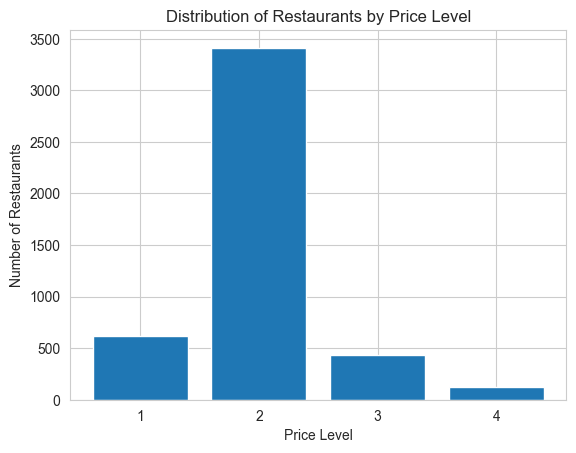

In [25]:
# Bar graph with price level on x-axis and count of restaurants on y-axis
price_counts = df_final['price_level'].value_counts().sort_index()
plt.bar(price_counts.index, price_counts.values)
plt.xlabel('Price Level')
plt.ylabel('Number of Restaurants')
plt.title('Distribution of Restaurants by Price Level')
plt.xticks(price_counts.index)
plt.show()

The majority of NYC restaurants in the dataset are in the 2nd price level ($$).df_final.columns

## Cuisine Analysis

In [44]:
import ast

# Ensure cuisine column is a proper list (if stored as string)
df_final["cuisine"] = df_final["cuisine"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Explode so each cuisine is its own row
df_cuisine = df_final.explode("cuisine")

# Ensure cuisine values are plain strings
df_cuisine["cuisine"] = df_cuisine["cuisine"].astype(str)

# Group and compute stats
cuisine_stats = (
    df_cuisine
        .groupby("cuisine", as_index=False)
        .agg(
            count=("name", "count"),
            avg_rating=("rating", "mean"),
            avg_price_level=("price_level", "mean"),
            num_reviews=("review_count", "sum") 
        )
        .sort_values("count", ascending=False)
        .head(10)
)

cuisine_stats.reset_index(drop=True, inplace=True)
print(cuisine_stats)

               cuisine  count  avg_rating  avg_price_level  num_reviews
0             american   1125    3.943111         2.072889     446164.0
1              italian    734    4.039510         2.148501     333280.0
2          newamerican    372    3.881720         2.309140     154833.0
3              chinese    362    3.730663         1.734807      99108.0
4                pizza    347    3.883285         1.668588     101106.0
5             japanese    341    3.994135         2.284457     130435.0
6     breakfast_brunch    336    3.875000         2.002976     151489.0
7         tradamerican    290    3.662069         2.089655     112721.0
8                 bars    285    3.831579         2.210526     122981.0
9  vegetarian_friendly    269    4.377323         2.000000      69957.0


               cuisine  avg_price_level  count  avg_rating
2          newamerican         2.309140    372    3.881720
5             japanese         2.284457    341    3.994135
8                 bars         2.210526    285    3.831579
1              italian         2.148501    734    4.039510
7         tradamerican         2.089655    290    3.662069
0             american         2.072889   1125    3.943111
6     breakfast_brunch         2.002976    336    3.875000
9  vegetarian_friendly         2.000000    269    4.377323
3              chinese         1.734807    362    3.730663
4                pizza         1.668588    347    3.883285


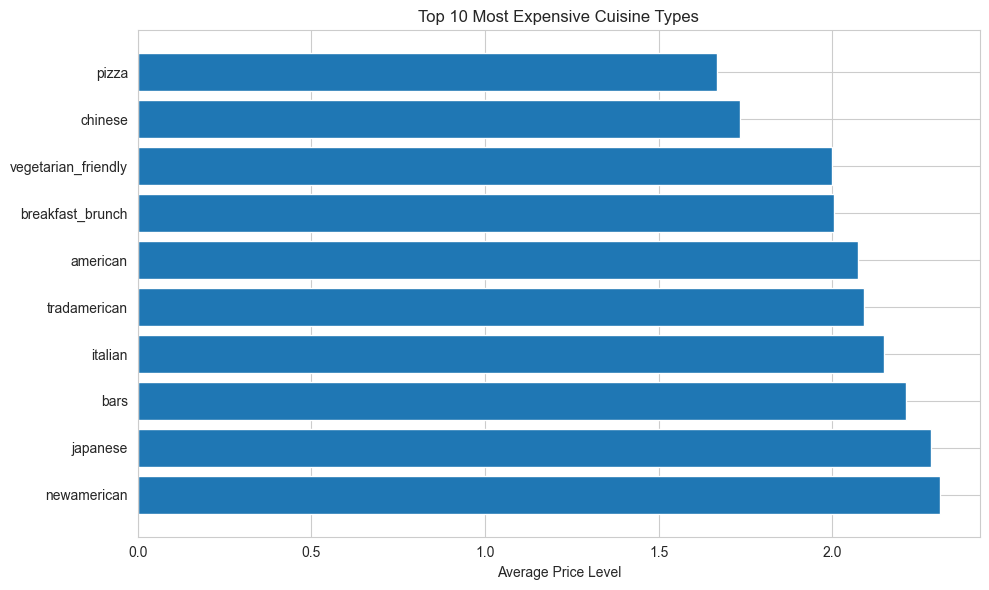

In [ ]:
# Find the most expensive cuisine types by average price level
most_expensive_cuisine = cuisine_stats.nlargest(10, 'avg_price_level')[['cuisine', 'avg_price_level', 'count', 'avg_rating']]
print(most_expensive_cuisine)

plt.figure(figsize=(10, 6))
plt.barh(most_expensive_cuisine['cuisine'], most_expensive_cuisine['avg_price_level'])
plt.xlabel('Average Price Level')
plt.title('Top 10 Most Expensive Cuisine Types')
plt.tight_layout()
plt.show()

## Rating Analysis

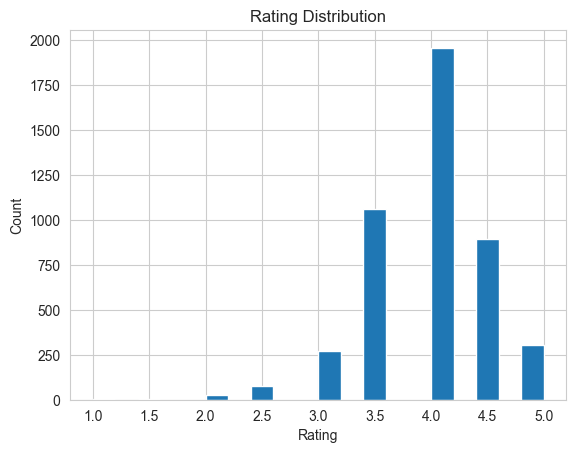

In [32]:
# Rating distribution histogram
plt.figure()
plt.hist(df_final['rating'], bins=20)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [30]:
# Calculate weighted rating using the formula: (v/(v+m) * R) + (m/(v+m) * C)
C = df_final['rating'].mean()
m = df_final['review_count'].quantile(0.75)

df_final['weighted_rating'] = (
    (df_final['review_count'] / (df_final['review_count'] + m)) * df_final['rating']
    + (m / (df_final['review_count'] + m)) * C
)

df_final[['name','rating','review_count','weighted_rating']].head()

,name,rating,review_count,weighted_rating
0,123 Burger Shot Beer,3.0,1000.0,3.328880
1,One Stop Patty Shop,4.0,40.0,3.951864
2,108 Food Dried Hot Pot,3.5,139.0,3.855246
3,Cookshop,4.0,1000.0,3.982047
4,11 Hanover Greek,4.0,122.0,3.957909
